In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.getcwd()

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
data_raw = pd.read_csv('/kaggle/input/mcdonalds-clf-multilabel-dsproject/df_tagB.csv')
#data_raw = pd.read_csv('.//data//df_tagB.csv')
data_raw = data_raw[data_raw.iloc[:,2:8].sum(axis=1)>0]

#df_tagB.csv



In [5]:
print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print("\n")
print("**Sample data:**")
data_raw.head()

In [6]:
data_raw = data_raw.iloc[:, 4:-5]
data_raw.shape
data_raw.head()

In [7]:
data = data_raw

In [8]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
# import re
# import sys
# import warnings

# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
# def cleanHtml(sentence):
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, ' ', str(sentence))
#     return cleantext
# def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
#     cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
#     cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
#     cleaned = cleaned.strip()
#     cleaned = cleaned.replace("\n"," ")
#     return cleaned
# def keepAlpha(sentence):
#     alpha_sent = ""
#     for word in sentence.split():
#         alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
#         alpha_sent += alpha_word
#         alpha_sent += " "
#     alpha_sent = alpha_sent.strip()
#     return alpha_sent
# data['review'] = data['review'].str.lower()
# data['review'] = data['review'].apply(cleanHtml)
# data['review'] = data['review'].apply(cleanPunc)
# data['review'] = data['review'].apply(keepAlpha)

In [9]:
# stemmer = SnowballStemmer("english")
# def stemming(sentence):
#     stemSentence = ""
#     for word in sentence.split():
#         stem = stemmer.stem(word)
#         stemSentence += stem
#         stemSentence += " "
#     stemSentence = stemSentence.strip()
#     return stemSentence
# data['review'] = data['review'].apply(stemming)

In [10]:
# data.head(5)

### set TF-IDF 

In [11]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(2,3), norm='l2')
# vectorizer.fit(train.review)
# vectorizer.fit(test.review)
# x_train = vectorizer.transform(train.review)
# y_train = train.drop(labels = ['id','review'], axis=1)
# x_test = vectorizer.transform(test.review)
# y_test = test.drop(labels = ['id','review'], axis=1)

In [12]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.multiclass import OneVsRestClassifier

In [13]:
# # Using pipeline for applying logistic regression and one vs rest classifier
# LogReg_pipeline = Pipeline([
#                 ('reg_clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])

In [14]:
# categories = data.columns[2:]

In [15]:
# for category in categories:
#     print('**Processing {} comments...**'.format(category))
    
#     # Training logistic regression model on train data
#     LogReg_pipeline.fit(x_train, train[category])
    
#     # calculating test accuracy
#     prediction = LogReg_pipeline.predict(x_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
#     print("\n")

In [16]:
######################################################################

In [17]:
#! conda install -c conda-forge pytorch-lightning

In [18]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

In [19]:
data.shape

In [20]:
df = data.copy()

In [21]:
df[df.iloc[:,2:8].sum(axis=1) > 0]

In [22]:
df.shape

In [23]:
import gc
del data
gc.collect()

In [24]:
train_df, val_df = train_test_split(df, test_size=0.25)
train_df.shape, val_df.shape

In [25]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [26]:
train_negative = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_positive = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  negative=[len(train_negative)],
  natural=[len(train_positive)]
)).plot(kind='barh');

In [27]:
train_df

In [28]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [29]:
LABEL_COLUMNS

In [30]:
sample_row = df.iloc[7]
sample_comment = sample_row.review
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_comment)
print()
print(sample_labels.to_dict())

In [31]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

In [32]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

In [33]:
encoding["input_ids"][0][0:40]

In [34]:
encoding["attention_mask"][0][0:200]

In [35]:
encoding["input_ids"].squeeze()[0:40]

In [36]:
#inverse the tokenization and get back (kinda) the words from the token id

print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:40])

In [37]:
# We need to specify the maximum number of tokens when encoding (512 is the maximum we can do)

token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["review"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
    
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [38]:
del token_counts, encoding
gc.collect()

In [39]:
# we’ll stick with the limit of 512

MAX_TOKEN_COUNT = 512

In [40]:
# We’ll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

class ToxicCommentsDataset(Dataset):
  def __init__(self,data: pd.DataFrame,tokenizer: BertTokenizer,max_token_len: int = 128):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    review = data_row.review
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      review=review,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [41]:
# Let’s have a look at a sample item from the dataset:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()


In [42]:
sample_item["review"]

In [43]:
sample_item["labels"]

In [44]:
sample_item["input_ids"].shape

In [45]:
# Let’s load the BERT model and pass a sample of batch data through

bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=4, pin_memory= True)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

In [46]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [47]:
output.last_hidden_state.shape, output.pooler_output.shape

In [48]:
# Note! - The 768 dimension comes from the BERT hidden size
bert_model.config.hidden_size
gc.collect()

In [49]:
# We’ll wrap our custom dataset into a LightningDataModule:
# ToxicCommentDataModule - encapsulates all data loading logic and returns the necessary data loaders

class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=4, pin_memory= True
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4 ,pin_memory= True
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4 , pin_memory= True
    )


In [50]:
# create an instance of our data module

N_EPOCHS = 10
BATCH_SIZE = 12
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)


## Model
**model** will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task.
We’ll pack everything in a LightningModule:

**points of interest** - are the way we configure the optimizers and calculating the area under ROC

In [51]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

**Optimizer schedule**r -The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We’ll use the get_linear_schedule_with_warmup.

In [52]:
#  simple example to make things clearer

dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

print('Linear learning rate scheduling over training steps')

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs

We’ll use a fifth of the training steps for a warm-up:

In [53]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

In [54]:
# create an instance of the model
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)


### Evaluation
We’ll use **Binary Cross Entropy** to measure the error for each label. PyTorch has **BCELoss**, which we’re going to combine with a sigmoid function (as we did in the model implementation)

In [55]:
# example - Loss Calc

criterion = nn.BCELoss()
prediction = torch.FloatTensor([10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213])

labels = torch.FloatTensor([1., 0., 0., 0., 1., 0.])

print(torch.sigmoid(prediction))
print(criterion(torch.sigmoid(prediction), labels))

In [56]:
# calculate the loss of the prediction

_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

In [57]:
criterion(predictions, sample_batch["labels"])

In [58]:
del sample_batch
gc.collect()

### ROC Curve
The area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR)

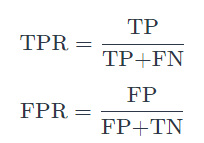

In [59]:
from sklearn import metrics
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

print('Example ROC value of a trained classifier vs random classifier')

### Training
we'll use at least 3 components - **Checkpointing** that saves the best model (based on validation loss):

In [60]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")

In [61]:
# Log the progress in TensorBoard:

logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [62]:
# And early stopping triggers when the loss hasn’t improved for the last 2 epochs 
#(you might want to remove/reconsider this when training on real-world projects):
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)



In [63]:
# start the training process:

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs= N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30)

In [64]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]

print(alldfs) 

In [66]:
del alldfs
gc.collect()

In [69]:
alldTS = [var for var in dir() if isinstance(eval(var), torch.Tensor)]

print(alldTS) 

In [74]:
# del _33, _34, _35, _43,_56, _57
# gc.collect()

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test()
gc.collect()

**Predictions**
mall sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Loading the best version (according to the validation loss) of our model:

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch was very dirty...high price"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

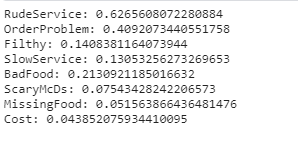

In [ ]:
THRESHOLD = 0.5
test_comment = "You are such a loser! very slow service!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

### Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

check the **ROC** for each tag



In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

Check the **classification report** for each class. To make this work, we must apply thresholding to the predictions

In [ ]:
gc.collect()

y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

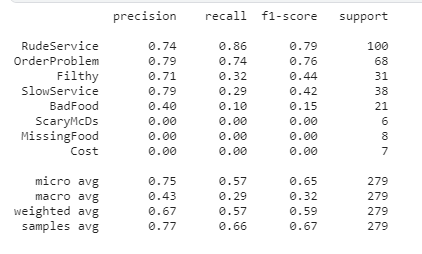

In [ ]:
print('finish')